In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import json

from sklearn.model_selection import (
    train_test_split, cross_val_score, ShuffleSplit, GridSearchCV)
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

from xgboost import XGBRegressor

In [151]:
df = pd.read_csv('/home/akeemlag/Downloads/car_price_prediction.csv')

In [152]:
"""EXPLORATORY DATA ANALYSIS"""

'EXPLORATORY DATA ANALYSIS'

In [153]:
df.head(20)

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
5,45802912,39493,891,HYUNDAI,Santa FE,2016,Jeep,Yes,Diesel,2,160931 km,4.0,Automatic,Front,04-May,Left wheel,White,4
6,45656768,1803,761,TOYOTA,Prius,2010,Hatchback,Yes,Hybrid,1.8,258909 km,4.0,Automatic,Front,04-May,Left wheel,White,12
7,45816158,549,751,HYUNDAI,Sonata,2013,Sedan,Yes,Petrol,2.4,216118 km,4.0,Automatic,Front,04-May,Left wheel,Grey,12
8,45641395,1098,394,TOYOTA,Camry,2014,Sedan,Yes,Hybrid,2.5,398069 km,4.0,Automatic,Front,04-May,Left wheel,Black,12
9,45756839,26657,-,LEXUS,RX 350,2007,Jeep,Yes,Petrol,3.5,128500 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12


In [154]:
print(df.shape)
print(df.info())

(19237, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-

In [155]:
df.nunique()

ID                  18924
Price                2315
Levy                  559
Manufacturer           65
Model                1590
Prod. year             54
Category               11
Leather interior        2
Fuel type               7
Engine volume         107
Mileage              7687
Cylinders              13
Gear box type           4
Drive wheels            3
Doors                   3
Wheel                   2
Color                  16
Airbags                17
dtype: int64

In [156]:
df.Levy.value_counts().sort_values(ascending=False)

Levy
-       5819
765      486
891      461
639      410
640      405
        ... 
2578       1
2421       1
1028       1
3141       1
3273       1
Name: count, Length: 559, dtype: int64

""" There roughly 6000 rows with this kind of data that are not int and not null
If we remove such humongous dataset, it will impact our ds training
Proposition is to conver the remaining value to an int, calculate the mean per year and replace the 
the - with the mean
"""

In [157]:
def isInt(x):
    try:
        int(x)
    except:
        return None
    return int(x)

In [158]:
df.Levy = (df.Levy.apply(isInt))
df.Levy = df.Levy.fillna(df.Levy.mean())
df.Levy = df.Levy.astype(int)

In [161]:
# Check if any cols contain values that are non int in the numerical cols
numerical_cols = df.select_dtypes(include=['int']).columns
print('numerical_cols: ', numerical_cols)
categorical_cols = df.select_dtypes(include=['object']).columns
print('categorical_cols: ',categorical_cols)

numerical_cols:  Index(['ID', 'Price', 'Levy', 'Prod. year', 'Airbags'], dtype='object')
categorical_cols:  Index(['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type',
       'Engine volume', 'Mileage', 'Gear box type', 'Drive wheels', 'Doors',
       'Wheel', 'Color'],
      dtype='object')


Let's create a corr heatmap to see features that are closely related 
Features with a 0.85 corr will dropped in place of that which does not 
have an outlier

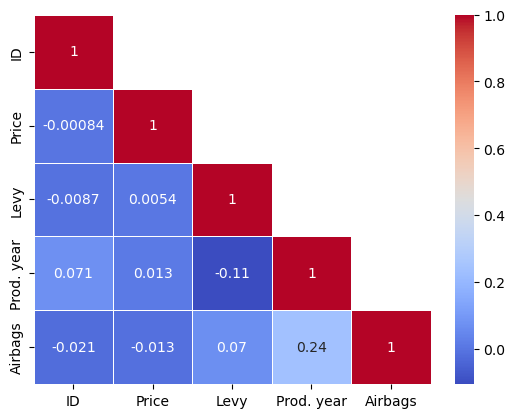

In [173]:
# Corr between numerical cols
corr = df[numerical_cols].corr()
# Remove repetition

mask = ~np.tri(corr.shape[0], k=0, dtype=bool)

sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5);